In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import csv
import io
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [11]:
num_lags = 3
timesteps = 4
err_range = 0.5

In [25]:
# read in data
df = pd.read_csv('../j17_well.csv')
pd.DataFrame.reset_index(df, drop=True)
del df['Site']
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores["DailyHighDate"] = df['DailyHighDate']
z_scores['WaterLevelElevation'] = df['WaterLevelElevation']
z_scores['Z Scores'], mean, std = z_score_calc(df,'WaterLevelElevation') # noramlization speeds up learning and leads to faster convergence
z_scores.to_csv("j17wl_daily_z_scores.csv") 
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    for j in range(gwl_num):
        if j == 0:
            name = 'GWL: t'
            list_data = data[gwl_num-j-1:len(data)-num_lags-j]
            result[name] = np.array(list_data)
        else:
            name = 'GWL: t+' + str(j)
            list_data = data[gwl_num-j-1:len(data)-num_lags-j]
            result[name] = np.array(list_data)
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
cols_x = []
for i in range(num_lags):
    cols_x.append(i+1)
cols_y = []
for i in range(timesteps):
    cols_y.append(num_lags+1+i)
# prepare data
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols_x)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=cols_y)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
ds_x = np.flip(ds_x,axis=0)
ds_y = np.flip(ds_y,axis=0)
# ~70% training
ds_train_x = ds_x[:int(0.7*len(ds_x))]
ds_train_y = ds_y[:int(0.7*len(ds_y))]
# ~20% validating
ds_val_x = ds_x[int(0.7*len(ds_x)):int(0.9*len(ds_x))]
ds_val_y = ds_y[int(0.7*len(ds_y)):int(0.9*len(ds_y))]
# ~10% testing
ds_test_x = ds_x[int(0.9*len(ds_y)):]
ds_test_y = ds_y[int(0.9*len(ds_y)):]

In [46]:
# build NN
epochs = 100
batch_size = 100
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='sigmoid', input_dim=num_lags))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(timesteps)) # output layer; gives a 1D output
model.compile(optimizer='adam', loss='mse')
history = model.fit(ds_train_x, ds_train_y, batch_size=batch_size, epochs=epochs, validation_data=(ds_val_x,ds_val_y), verbose=2)
# apply to predictions

Epoch 1/100
221/221 - 1s - loss: 0.3632 - val_loss: 0.0287
Epoch 2/100
221/221 - 0s - loss: 0.0240 - val_loss: 0.0235
Epoch 3/100
221/221 - 0s - loss: 0.0167 - val_loss: 0.0212
Epoch 4/100
221/221 - 0s - loss: 0.0128 - val_loss: 0.0176
Epoch 5/100
221/221 - 0s - loss: 0.0108 - val_loss: 0.0163
Epoch 6/100
221/221 - 0s - loss: 0.0096 - val_loss: 0.0150
Epoch 7/100
221/221 - 0s - loss: 0.0089 - val_loss: 0.0142
Epoch 8/100
221/221 - 0s - loss: 0.0084 - val_loss: 0.0135
Epoch 9/100
221/221 - 0s - loss: 0.0079 - val_loss: 0.0122
Epoch 10/100
221/221 - 0s - loss: 0.0075 - val_loss: 0.0115
Epoch 11/100
221/221 - 0s - loss: 0.0070 - val_loss: 0.0110
Epoch 12/100
221/221 - 0s - loss: 0.0066 - val_loss: 0.0106
Epoch 13/100
221/221 - 0s - loss: 0.0063 - val_loss: 0.0102
Epoch 14/100
221/221 - 0s - loss: 0.0060 - val_loss: 0.0090
Epoch 15/100
221/221 - 0s - loss: 0.0056 - val_loss: 0.0084
Epoch 16/100
221/221 - 0s - loss: 0.0053 - val_loss: 0.0079
Epoch 17/100
221/221 - 0s - loss: 0.0052 - val_lo

In [47]:
predictions = model.predict(ds_test_x)
pred_vals = predictions*std+mean
test_vals = ds_test_y*std+mean
result = []
for i in range(len(predictions)):
    result.append(test_vals[i]-pred_vals[i])
result = np.array(result)
count_err = 0
count_1 = 0
for i in result:
    for j in i:
        if abs(j) <= err_range:
          count_err += 1
        if abs(j) <= 1.0:
          count_1 += 1
print("Predictions ±" + str(err_range) + " = " + str(count_err / len(diff) / timesteps * 100) + "%")
print("Predictions ±1.0 = " + str(count_1 / len(diff) / timesteps * 100) + "%")
corr_m = np.corrcoef(pred_vals, test_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")

Predictions ±0.5 = 49.730757047830224%
Predictions ±1.0 = 73.63002850807729%
R2 = 99.13447344787599%


In [43]:
plt.rcParams['font.family'] = 'serif'
f='Times'

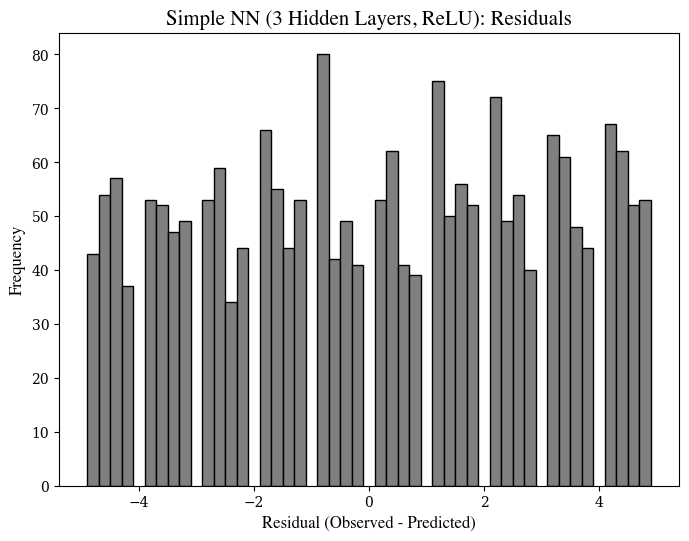

In [49]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

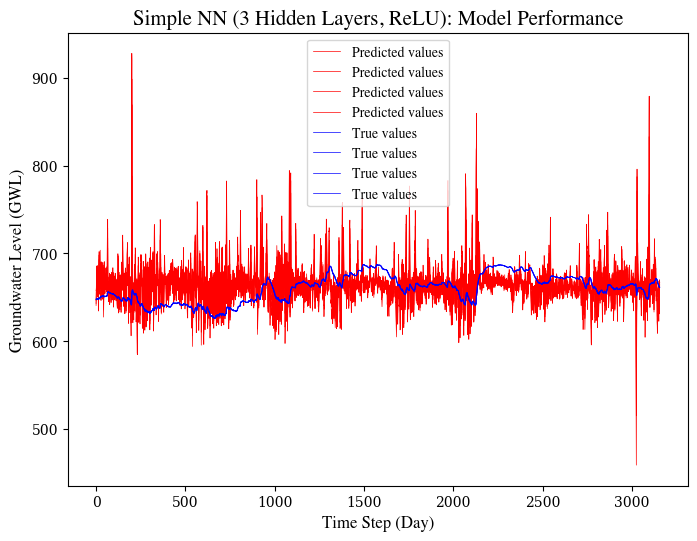

In [45]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})

In [26]:
model.save("simple_nn_D")

INFO:tensorflow:Assets written to: simple_nn_D/assets


In [27]:
plt.rcParams['font.family'] = 'sans-serif'
f='Avenir'

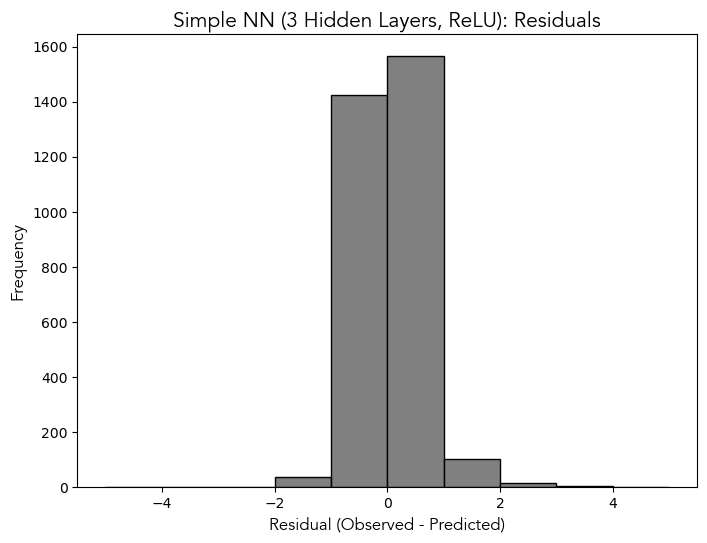

In [28]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

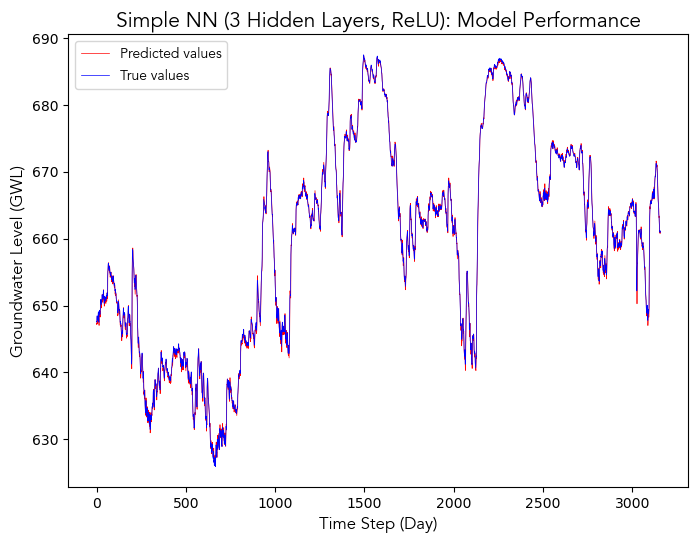

In [29]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("Simple NN (3 Hidden Layers, ReLU): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})